### Bert model v 01
---

In [7]:
import os
import re
from PyPDF2 import PdfReader
from datetime import datetime
from PyPDF2.generic import IndirectObject
import json
import pdfplumber


1. Data Collection and Preparation:
---

In [2]:
# Helping functions to extract metadata from PDF files
def resolve_metadata_value(value):
    if isinstance(value, IndirectObject):
        value = value.get_object()
    return str(value) if value is not None else None

In [14]:
# Helping function
def extract_pdf_info(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        #reader = PdfReader(file)
        text = ''
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text

        metadata = pdf.metadata
        if metadata is not None:
            title = resolve_metadata_value(metadata.get('/Title')) or 'Unknown Title'
            author = resolve_metadata_value(metadata.get('/Author')) or 'Unknown Author'
            creation_date = resolve_metadata_value(metadata.get('/CreationDate')) or ''
            mod_date = resolve_metadata_value(metadata.get('/ModDate')) or ''
        else:
            title = 'Unknown Title'
            author = 'Unknown Author'
            creation_date = ''
            mod_date = ''

        # Extract date from metadata
        date_str = creation_date or mod_date
        date = None
        if date_str:
            date_match = re.search(r"D:(\d{14})", date_str)
            if date_match:
                try:
                    date = datetime.strptime(date_match.group(1), '%Y%m%d%H%M%S')
                except ValueError:
                    pass  # Handle invalid date format gracefully

        return {'title': title, 'author': author, 'date': date, 'text': text}



*Create a dictionary from the Public database, with keys: title, author, date, text, and filename*

In [15]:
# Directory containing data as PDFs
pdf_dir = '../data/AWS/'

In [10]:
!pip install tqdm
from tqdm import tqdm

In [11]:
import time

In [ ]:
# runtime was 120 min
pdf_info_list = []

for pdf_file in tqdm(os.listdir(pdf_dir), desc="Processing PDFs"):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        pdf_info = extract_pdf_info(pdf_path)
        pdf_info['filename'] = pdf_file
        pdf_info_list.append(pdf_info)


Processing PDFs:   0%|          | 0/709 [00:00<?, ?it/s]CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
Processing PDFs:   0%|          | 1/709 [00:00<08:13,  1.44it/s]CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missi

*Second, Create a dictionary from the podcasts and book, with keys: title, author, date, text, and filename*

In [17]:
# Directory containing additional PDFs
pdf_dir = '../data/Training_docs/'

In [20]:
#Aditional list with proven docs
pdf_proven_list = []

for pdf_file in tqdm(os.listdir(pdf_dir), desc="Processing PDFs"):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        pdf_info = extract_pdf_info(pdf_path)
        pdf_info['filename'] = pdf_file
        pdf_proven_list.append(pdf_info)


Processing PDFs:   0%|          | 0/11 [00:00<?, ?it/s]CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page,

*Finally, create a dictionary from the sections of the book, with keys: title, author, date, text, and filename*

In [21]:
# Directory containing additional PDFs
pdf_dir = '../data/tokenized_sections'

In [22]:
#Aditional list with proven docs
pdf_book_sections_list = []

for pdf_file in tqdm(os.listdir(pdf_dir), desc="Processing PDFs"):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        pdf_info = extract_pdf_info(pdf_path)
        pdf_info['filename'] = pdf_file
        pdf_book_sections_list.append(pdf_info)


Processing PDFs:   0%|          | 0/20 [00:00<?, ?it/s]CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page,

In [23]:
# Combine with existing pdf_info_list
combined_data = pdf_info_list + pdf_proven_list + pdf_book_sections_list

*let's save them for future use if needed*

In [24]:
# save the combined_data to a JSON file
# Define a serialization function for datetime objects
def serialize_datetime(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()
    raise TypeError(f"Type {type(obj)} not serializable")

# Save the combined data to a JSON file
with open('../data/combined_data.json', 'w') as json_file:
    json.dump(combined_data, json_file, default=serialize_datetime, indent=4)

In [25]:
# save the pdf_info_list to a JSON file
# Define a serialization function for datetime objects
def serialize_datetime(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()
    raise TypeError(f"Type {type(obj)} not serializable")

# Assuming pdf_info_list is your list of dictionaries
with open('../data/pdf_info_list.json', 'w') as json_file:
    json.dump(pdf_info_list, json_file, default=serialize_datetime, indent=4)


*Assign labels and save only the combined data*

In [26]:
# Define your list of healthspan-related keywords
healthspan_keywords = ['longevity', 'aging', 'senescence', 'lifespan', 'healthspan', 'caloric restriction', 'telomere', 'autophagy', 'gerontology', 'anti-aging', 'resveratrol', 'sirtuins', 'mTOR', 'NAD+', 'oxidative stress', 'inflammation', 'mitochondria', 'genomics', 'epigenetics', 'stem cells', 'regeneration', 'DNA repair', 'protein folding', 'calorie restriction', 'intermittent fasting', 'blue zones', 'hormesis', 'geroprotector', 'rapamycin', 'metformin', 'amyloids', 'proteostasis', 'senolytics', 'leptin', 'circadian rhythm', 'sleep', 'exercise', 'diet', 'nutrition', 'microbiome', 'gut health', 'probiotics', 'prebiotics', 'polyphenols', 'flavonoids', 'antioxidants','hormone replacement', 'testosterone', 'stress management', 'mindfulness', 'meditation', 'cognitive function', 'neuroplasticity', 'brain health']

In [27]:
healthspan_keywords.__len__()

54

In [32]:
def label_document(text, keywords, threshold=3):
 """Assign a label based on the presence of at least 3 healthspan-related keywords."""
 text_lower = text.lower()
 count = sum(1 for keyword in keywords if keyword in text_lower)
 return 1 if count >= threshold else 0



In [33]:
# Apply labeling to each document
for pdf in combined_data:
 pdf['label'] = label_document(pdf['text'], healthspan_keywords)

# renundantly, unneded but it may be useful
#for pdf in pdf_info_list:
#    pdf['label'] = label_document(pdf['text'], healthspan_keywords)

In [34]:
# Save the labeled data to a new JSON file
# Define a serialization function for datetime objects
def serialize_datetime(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()
    raise TypeError(f"Type {type(obj)} not serializable")

# this is our list of dictionaries
with open('../data/combined_data.json', 'w') as json_file:
    json.dump(combined_data, json_file, default=serialize_datetime, indent=4)

---
2. Text preprocessing.
---

In [35]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\email\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\email\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove excessive spaces
    text = re.sub(r'[^a-z0-9.,!?\-\s]', '', text)  # Remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)



In [ ]:
# Apply preprocessing to each document with a progress bar
for pdf in tqdm(pdf_info_list, desc="Processing PDFs"):
    pdf['processed_text'] = preprocess_text(pdf['text'])

In [ ]:
# Apply preprocessing to each document with a progress bar
# runningtime was 59 min
for pdf in tqdm(combined_data, desc="Processing PDFs"):
    pdf['processed_text'] = preprocess_text(pdf['text'])

Processing PDFs: 100%|██████████| 740/740 [59:17<00:00,  4.81s/it]  


In [39]:
# save to file
with open('../data/preprocessed_combined_data.json', 'w') as json_file:
    json.dump(combined_data, json_file, default=serialize_datetime, indent=4)

#with open('../data/preprocessed_pdf_info_list.json', 'w') as json_file:
#    json.dump(pdf_info_list, json_file, default=serialize_datetime, indent=4)

---
3. Split dataset between train and eval
---

In [41]:
import json

In [42]:
# Prepare data
texts = [pdf['processed_text'] for pdf in combined_data]
labels = [pdf['label'] for pdf in combined_data]



In [ ]:


# Load the dataset from the JSON file
with open('../data/preprocessed_combined_data.json', 'r') as file:
    data = json.load(file)

# Extract texts and labels
texts = [entry['processed_text'] for entry in data]
labels = [entry['label'] for entry in data]


In [ ]:
# Create dataset
#dataset = HealthspanDataset(texts, labels, tokenizer, max_len=512)



In [45]:
from sklearn.model_selection import train_test_split

# Split the data: 80% for training, 20% for evaluation
texts_train, texts_eval, labels_train, labels_eval = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)


In [48]:
# Verify the integrity of the data
# Check for None or empty strings in your training data
for i, text in enumerate(texts_train):
    if text is None or (isinstance(text, str) and text.strip() == ""):
        print(f"Empty or None text found at index {i}")


---
4. Model Selection and Training
---

Let's try with BioBERT

In [49]:
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    get_scheduler,
    EarlyStoppingCallback
)


c:\Users\email\Desktop\DS_Science_Youth_Extension\2504_Science_Youth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
from torch.optim import AdamW


In [51]:
class HealthspanDataset(Dataset):
   def __init__(self, texts, labels, tokenizer_name , max_len, default_text="default"):
        # Filter out None, empty, or whitespace-only strings
        self.texts = [str(text) if isinstance(text, (str, int, float)) and str(text).strip() else default_text for text in texts]
        self.labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.max_len = max_len

   def __len__(self):
       return len(self.texts)

   def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        # Ensure text is a string
        if not isinstance(text, str):
            text = str(text)
        try:    
            encoding = self.tokenizer(
                text,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                #is_split_into_words=False  # Ensure this is set to False
            )
            return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long),
            }
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            print(f"Problematic text: {text}")
            raise

In [52]:
# Define maximum sequence length
MAX_LEN = 512

In [53]:
# Initialize BioBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")



In [54]:
# Create dataset instances
train_dataset = HealthspanDataset(texts_train, labels_train, tokenizer, max_len=MAX_LEN)
eval_dataset = HealthspanDataset(texts_eval, labels_eval, tokenizer, max_len=MAX_LEN)

In [57]:
# Initialize BioBERT model
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=2)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=4,
   per_device_train_batch_size=8,
   per_device_eval_batch_size=8,
   warmup_steps=500,
   weight_decay=0.01,
   logging_dir='./logs',
   eval_strategy="epoch",
   save_strategy="epoch",  # Ensure this matches evaluation_strategy
   load_best_model_at_end=True,
   metric_for_best_model="eval_loss",  # Or another metric you're monitoring
   greater_is_better=False,  # Set to True if a higher metric is better
)



c:\Users\email\Desktop\DS_Science_Youth_Extension\2504_Science_Youth\.venv\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_training_steps = len(train_dataset) * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


In [60]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Ensure you have an evaluation dataset
    optimizers=(optimizer, lr_scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [ ]:
# Train model
# Running time was 4h 30 min
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.675932
2,No log,0.633234
3,No log,0.696217
4,No log,0.637503


TrainOutput(global_step=296, training_loss=0.6178270288415857, metrics={'train_runtime': 15477.5029, 'train_samples_per_second': 0.153, 'train_steps_per_second': 0.019, 'total_flos': 623046979092480.0, 'train_loss': 0.6178270288415857, 'epoch': 4.0})

In [62]:
model.save_pretrained('../models/biobert_healthspan')

In [63]:
tokenizer.save_pretrained('../models/biobert_healthspan')

('../models/biobert_healthspan\\tokenizer_config.json',
 '../models/biobert_healthspan\\special_tokens_map.json',
 '../models/biobert_healthspan\\vocab.txt',
 '../models/biobert_healthspan\\added_tokens.json',
 '../models/biobert_healthspan\\tokenizer.json')

---
5. Evaluation
---

In [64]:
eval_results = trainer.evaluate()


In [65]:
print(eval_results)

{'eval_loss': 0.6332338452339172, 'eval_runtime': 264.6981, 'eval_samples_per_second': 0.559, 'eval_steps_per_second': 0.072, 'epoch': 4.0}


In [81]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch
from datasets import Dataset

In [ ]:
# Define a simple dataset class
#class EvalDataset(Dataset):
#    def __init__(self, encodings):
#        self.encodings = encodings

#    def __len__(self):
#        return len(self.encodings["input_ids"])

#    def __getitem__(self, idx):
#        return {key: val[idx] for key, val in self.encodings.items()}

In [85]:
# Tokenize evaluation texts with proper truncation and max length
tokenized_eval = tokenizer(texts_eval, padding=True, truncation=True, max_length=512)

In [86]:
# Ensure tokenized inputs have correct length
for key in tokenized_eval:
    tokenized_eval[key] = [seq[:512] for seq in tokenized_eval[key]]

In [87]:
dataset_eval = Dataset.from_dict({
    'input_ids': tokenized_eval['input_ids'],
    'attention_mask': tokenized_eval['attention_mask'],
    'labels': labels_eval
})

In [88]:
# Convert dataset to PyTorch format to avoid shape mismatches
dataset_eval.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
# Convert tokenized inputs into a dataset
#eval_dataset = EvalDataset(tokenized_eval)

In [89]:
# Get model predictions
predictions = trainer.predict(dataset_eval).predictions
y_pred = np.argmax(predictions, axis=1)

In [90]:
# Ground truth labels
y_true = labels_eval

In [91]:
# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

In [92]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.6891891891891891
Precision: 0.7251948236200205
Recall: 0.6891891891891891
F1 Score: 0.6427114614614614


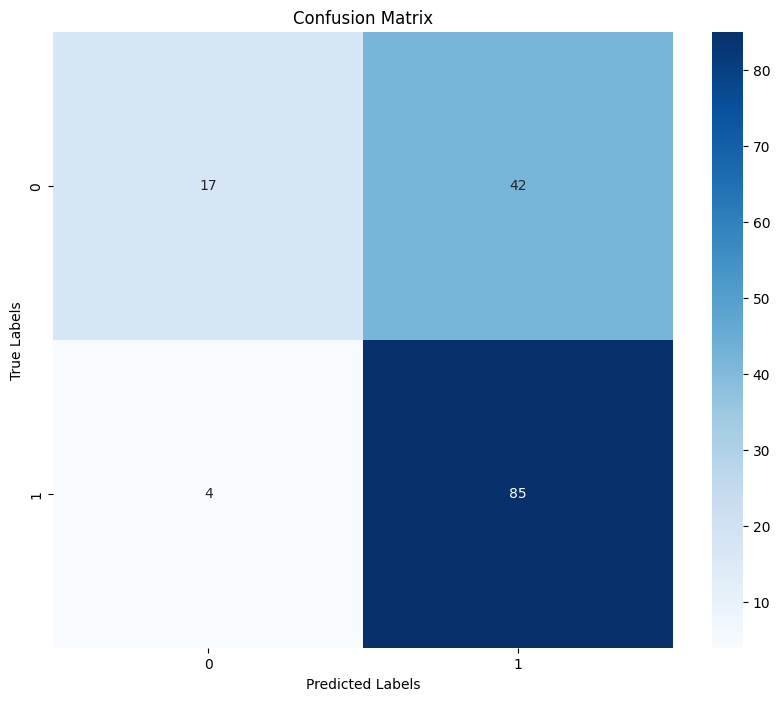

<Figure size 640x480 with 0 Axes>

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Save the confusion matrix plot
plt.savefig('../data/confusion_matrix.png')

---